## Sources of congestion on the Taipei Metro
In this notebook, I tried to find the sources that congest some routes between two neighboring stations.

- Dataset
     - OD (2021-04).
     - Stations.
     - Transfer stations.
     - Path.
- Process
     - A. [Data loading.](#A.-Data-Loading)
     - B. [Data cleaning.](#B.-Data-Cleaning)
     - C. [Exploratory data analysis.](#C.-Exploratory-Data-Analysis)
     - D. [Visualization.](#D.-Visualization)

In [243]:
import requests
from urllib.parse import quote

import pandas as pd
import numpy as np

from itertools import permutations
from time import sleep
from random import randint

import multiprocessing
from tqdm.notebook import trange, tqdm
import os

import matplotlib.pyplot as plt
import seaborn as sns

--- 
### A. Data Loading
All datasets are requested by open data API.
1. [OD data (2021-04)](#1.-OD-Data)
2. [Stations data](#2.-Stations-Data)
3. [Path data](#3.-Path-Data)
4. [Transfer stations data](#4.-Transfer-Stations-Data)
---

#### 1. OD Data
- api url: https://data.taipei/api/v1/dataset/555d84c1-5a25-4644-85e2-bd1284a7482e?scope=resourceAquire
- source: https://data.taipei/#/dataset/detail?id=63f31c7e-7fc3-418b-bd82-b95158755b4d

In [234]:
# Get all OD data url
od_url = "https://data.taipei/api/v1/dataset/555d84c1-5a25-4644-85e2-bd1284a7482e?scope=resourceAquire"
od_res = requests.get(od_url)
od_results = od_res.json()['result']['results']
od_results

[{'\ufeff年月': '201701',
  '_id': 1,
  '資料路徑': 'http://tcgmetro.blob.core.windows.net/stationod/臺北捷運每日分時各站OD流量統計資料_201701.csv'},
 {'\ufeff年月': '201702',
  '_id': 2,
  '資料路徑': 'http://tcgmetro.blob.core.windows.net/stationod/臺北捷運每日分時各站OD流量統計資料_201702.csv'},
 {'\ufeff年月': '201703',
  '_id': 3,
  '資料路徑': 'http://tcgmetro.blob.core.windows.net/stationod/臺北捷運每日分時各站OD流量統計資料_201703.csv'},
 {'\ufeff年月': '201704',
  '_id': 4,
  '資料路徑': 'http://tcgmetro.blob.core.windows.net/stationod/臺北捷運每日分時各站OD流量統計資料_201704.csv'},
 {'\ufeff年月': '201705',
  '_id': 5,
  '資料路徑': 'http://tcgmetro.blob.core.windows.net/stationod/臺北捷運每日分時各站OD流量統計資料_201705.csv'},
 {'\ufeff年月': '201706',
  '_id': 6,
  '資料路徑': 'http://tcgmetro.blob.core.windows.net/stationod/臺北捷運每日分時各站OD流量統計資料_201706.csv'},
 {'\ufeff年月': '201707',
  '_id': 7,
  '資料路徑': 'http://tcgmetro.blob.core.windows.net/stationod/臺北捷運每日分時各站OD流量統計資料_201707.csv'},
 {'\ufeff年月': '201708',
  '_id': 8,
  '資料路徑': 'http://tcgmetro.blob.core.windows.net/stationod/臺北捷運每日分時各

In [235]:
# Load 2021-04 OD data
file = od_results[-2]['資料路徑']
file_url = quote(file).replace('%3A', ':')

od = pd.read_csv(file_url)
od.rename(columns = {'日期': 'date', 
                     '時段': 'time',
                     '進站': 'startS_name', 
                     '出站': 'endS_name', 
                     '人次': 'person'},
          inplace = True)

od.head()

,date,time,startS_name,endS_name,person
0,2021-04-01,0,松山機場,松山機場,1
1,2021-04-01,0,松山機場,中山國中,0
2,2021-04-01,0,松山機場,南京復興,0
3,2021-04-01,0,松山機場,忠孝復興,0
4,2021-04-01,0,松山機場,大安,0


#### 2. Stations Data
- source: https://www.metro.taipei/cp.aspx?n=ECEADC266D7120A7
- api requests
    - url: https://web.metro.taipei/apis/metrostationapi/menuline
    - headers
        - 'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
    - preload: {"LineID": "0", "Lang": "tw"}

In [417]:
station_url = 'https://web.metro.taipei/apis/metrostationapi/menuline'
headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'}
data = {"LineID": "0", "Lang": "tw"}
req = requests.post(station_url, headers = headers, json = data)

stat_data = []

[stat_data.extend(line['LineStations']) for line in req.json()]
station = pd.DataFrame(stat_data)

print(station.SID.unique())

# mismatch of station name between OD and station data
station.at[130, 'StationName'] = 'Y板橋'  # 板橋
station.at[104, 'StationName'] = 'BL板橋' # 板橋
station.at[83, 'StationName'] = '大橋頭站' # 大橋頭

station.at[130, 'StationLabelForRoadmap'] = 'BL07 Y16' # Y板橋
station.at[104, 'StationLabelForRoadmap'] = 'BL07 Y16' # BL板橋

station.at[105, 'StationLabelForRoadmap'] = 'Y17 BL08' # 新埔
station.at[131, 'StationLabelForRoadmap'] = 'Y17 BL08' # 新埔民生

station = station.drop_duplicates(subset = 'StationName', keep = 'first')

station

['019' '018' '017' '016' '015' '014' '013' '012' '011' '010' '009' '008'
 '007' '021' '022' '023' '024' '025' '026' '027' '028' '029' '030' '031'
 '099' '100' '101' '103' '134' '042' '050' '051' '053' '054' '055' '056'
 '057' '058' '059' '060' '061' '062' '063' '064' '065' '066' '067' '068'
 '069' '070' '071' '033' '034' '035' '032' '036' '037' '038' '039' '040'
 '041' '043' '086' '105' '132' '109' '110' '111' '048' '047' '046' '045'
 '089' '131' '130' '128' '127' '126' '125' '124' '123' '122' '121' '180'
 '179' '178' '177' '176' '175' '174' '076' '077' '078' '079' '080' '081'
 '082' '083' '084' '085' '088' '091' '092' '093' '094' '095' '096' '097'
 '201' '202' '203' '205' '206' '207' '208' '209' '210' '212' '213']


,SID,LineID,StationLabel,StationLabelForRoadmap,StationName,Lang
0,019,1,BR01,BR01,動物園,None
1,018,1,BR02,BR02,木柵,None
2,017,1,BR03,BR03,萬芳社區,None
3,016,1,BR04,BR04,萬芳醫院,None
4,015,1,BR05,BR05,辛亥,None
...,...,...,...,...,...,...
129,208,6,Y15,Y15,板新,None
130,209,6,Y16,BL07 Y16,Y板橋,None
131,210,6,Y17,Y17 BL08,新埔民生,None
133,212,6,Y19,Y19,幸福,None


#### 3. Path Data
- source: https://www.metro.taipei/cp.aspx?n=ECEADC266D7120A7
- api requests
    - url: https://web.metro.taipei/apis/metrostationapi/routetimepathinfo
    - headers
        - 'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'
    - preload: {"StartSID": "081", "EndSID": "045", "Lang": "tw"}

In [241]:
def opt_path(StartSID, EndSID):
    # input StartSID (str), EndSID (str)
    # output path_info (dict)
    
    url = 'https://web.metro.taipei/apis/metrostationapi/routetimepathinfo'
    headers = {'user-agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'}
    data = {"StartSID": StartSID, "EndSID": EndSID, "Lang": "tw"}

    req = requests.post(url, headers = headers, json = data)

    return req.json()

# Example
# Note: the station ID is in the "SID" column of station data.
opt_path("081", "045")

{'StartSID': '081',
 'EndSID': '045',
 'StartStationName': '府中',
 'EndStationName': '頂溪',
 'TravelTime': '24',
 'Path': '搭乘板南線（往南港展覽館）=> 西門站轉乘松山新店線（往台電大樓/往新店）=> 古亭站轉乘中和新蘆線（往南勢角）',
 'Lang': 'tw'}

In [244]:
# The following block crawls the data from Taipei Metro website.
# Please just import the path data that was already crawled and cleaned instead of crawling them again.z
# ----------------------------------------------------------------------------------------

# possible_permutation = list(permutations(station.SID.unique(), 2))
# possible_permutation_count = len(possible_permutation)

# opt_path_df = pd.DataFrame(columns = ['StartSID', 'EndSID', 
#                                      'StartStationName', 'EndStationName',
#                                      'TravelTime', 'Path'])

# for i in trange(len(opt_path_df), possible_permutation_count):
#     data = opt_path(possible_permutation[i][0], possible_permutation[i][1])
#     opt_path_df = opt_path_df.append(data, ignore_index = True)
        
#     sleep(0.5)

# opt_path_df.to_csv(r'/the_directory/the_file_name.csv', index=False, header=True)

# ----------------------------------------------------------------------------------------

In [4]:
optimal_path = pd.read_csv('/Users/c.cheng/Desktop/analysis_v4/optimal_path.csv', dtype=object)
optimal_path

,StartSID,EndSID,StartStationName,EndStationName,TravelTime,Path,Lang
0,019,018,動物園,木柵,2,搭乘文湖線（往南港展覽館）,tw
1,019,017,動物園,萬芳社區,3,搭乘文湖線（往南港展覽館）,tw
2,019,016,動物園,萬芳醫院,5,搭乘文湖線（往南港展覽館）,tw
3,019,015,動物園,辛亥,7,搭乘文湖線（往南港展覽館）,tw
4,019,014,動物園,麟光,10,搭乘文湖線（往南港展覽館）,tw
...,...,...,...,...,...,...,...
14037,213,207,新北產業園區,中原,17,搭乘環狀線（往大坪林）,tw
14038,213,208,新北產業園區,板新,14,搭乘環狀線（往大坪林）,tw
14039,213,209,新北產業園區,板橋,11,搭乘環狀線（往大坪林）,tw
14040,213,210,新北產業園區,新埔民生,8,搭乘環狀線（往大坪林）,tw


#### 4. Transfer Stations Data
- api url: https://data.taipei/api/v1/dataset/14fd1af0-dc2b-4174-87d4-fcb9de783496?scope=resourceAquire
- source: https://data.taipei/#/dataset/detail?id=782c2b71-8f5a-4575-9bf2-e86999be2863

In [419]:
transfer_url = "https://data.taipei/api/v1/dataset/14fd1af0-dc2b-4174-87d4-fcb9de783496?scope=resourceAquire"
transfer_res = requests.get(transfer_url)
res_results = transfer_res.json()['result']['results']

sta_arr = [s['station'].replace('捷運', '').replace('站', '') for s in res_results]

transfer_stations = {}

for sta in sta_arr:
    sta_label = station[station.StationName.str.contains(sta)].StationLabelForRoadmap.iat[0].split(' ')
    transfer_stations[sta] = sta_label
    
# customized transfer statios - 站外轉乘 or missing data (大坪林) or wrong data (中山)
transfer_stations['新埔'] = ['Y17', 'BL08']
transfer_stations['新埔民生'] = ['Y17', 'BL08']
transfer_stations['板南線板橋'] = ['BL07', 'Y16']
transfer_stations['環狀線板橋'] = ['BL07', 'Y16']
transfer_stations['大坪林'] = ['Y07', 'G04']
transfer_stations['中山'] = ['G14', 'R11']

transfer_stations

{'北投': ['R22'],
 '民權西路': ['O11', 'R13'],
 '忠孝新生': ['BL14', 'O07'],
 '忠孝復興': ['BL15', 'BR10'],
 '台北車': ['BL12', 'R10'],
 '中正紀念堂': ['G10', 'R08'],
 '古亭': ['G09', 'O05'],
 '七張': ['G03'],
 '南港展覽館': ['BL23', 'BR24'],
 '西門': ['BL11', 'G12'],
 '大橋頭': ['O12'],
 '東門': ['R07', 'O06'],
 '大安': ['R05', 'BR09'],
 '南京復興': ['G16', 'BR11'],
 '松江南京': ['G15', 'O08'],
 '中山': ['G14', 'R11'],
 '景安': ['Y11', 'O02'],
 '板橋': ['BL07', 'Y16'],
 '新埔': ['Y17', 'BL08'],
 '新埔民生': ['Y17', 'BL08'],
 '頭前庄': ['Y18', 'O17'],
 '板南線板橋': ['BL07', 'Y16'],
 '環狀線板橋': ['BL07', 'Y16'],
 '大坪林': ['Y07', 'G04']}

---
### B. Data Cleaning
    Objective: From station (OD) to route data.
        - OD: the person count from A to B on D date at T time.
             - Cannot reflect the route go through by each person count.
        - Route: the path between two neighboring stations.
            - It matters because we can know the degree of congestion on specific route and time.
            - Moreover, it shows the sources (start and end stations) of each person count in each route.
            
            
- 1. [Merge OD and Station data.](#1.-Merge-OD-and-Station-Data)
- 2. [Create OD to route converter.](#2.-Create-OD-to-Route-Converter)
- 3. [Convert OD to route data.](#3.-Convert-OD-to-Route-Data)
---

#### 1. Merge OD and Station Data

In [420]:
start_station = station.rename(columns = {'StationName': 'startS_name'}, inplace = False)
end_station = station.rename(columns = {'StationName': 'endS_name'}, inplace = False)

od_s = (
    pd.merge(od, start_station, how = "left", on = ["startS_name"])
    .drop(['LineID', 'StationLabel', 'Lang'], axis = 1, inplace = False)
    .rename(columns = {'SID': 'startS_id', 
                       'StationLabelForRoadmap': 'startS_label'},
            inplace = False)
)

mod = (
    pd.merge(od_s, end_station, how = "left", on = ["endS_name"])
    .drop(['LineID', 'StationLabel', 'Lang'], axis = 1, inplace = False)
    .rename(columns = {'SID': 'endS_id', 
                       'StationLabelForRoadmap': 'endS_label'},
            inplace = False)
)

mod = mod[(mod.startS_name != mod.endS_name) & (mod.person > 0)]

mod

,date,time,startS_name,endS_name,person,startS_id,startS_label,endS_id,endS_label
13,2021-04-01,0,松山機場,大直,1,007,BR13,021,BR14
23,2021-04-01,0,松山機場,南港展覽館,1,007,BR13,031,BL23 BR24
54,2021-04-01,0,松山機場,新北投,1,007,BR13,065,R22A
65,2021-04-01,0,松山機場,亞東醫院,1,007,BR13,080,BL05
68,2021-04-01,0,松山機場,新埔,1,007,BR13,083,Y17 BL08
...,...,...,...,...,...,...,...,...,...
8921424,2021-04-30,23,新北產業園區,中原,2,213,Y20,207,Y14
8921425,2021-04-30,23,新北產業園區,板新,3,213,Y20,208,Y15
8921426,2021-04-30,23,新北產業園區,Y板橋,12,213,Y20,209,BL07 Y16
8921427,2021-04-30,23,新北產業園區,新埔民生,5,213,Y20,210,Y17 BL08


#### 2. Create OD to Route Converter

In [434]:
global transfer_stations
global optimal_path
global digits

digits = '1234567890'


def route_detail(route):
    # input: route (dataframe with 1 row)
    # output: route detail (dataframe with n row)
        
    try:

        path = (
            optimal_path[(optimal_path.StartSID==route.startS_id.iat[0]) & (optimal_path.EndSID==route.endS_id.iat[0])]
            .Path.iat[0]
            .replace(' ', '')
            .split('=>')
        )
        
        pass_by = pass_by_station(path)
        
        pass_by.append(route.endS_label.iat[0].split(' '))
        pass_by.insert(0, route.startS_label.iat[0].split(' '))
        
        split_route = arrange_split_route(pass_by)
        
        route_df = pd.DataFrame()

        for r in split_route:
            startS_line = r[0].translate(str.maketrans('', '', digits))
            endS_line = r[1].translate(str.maketrans('', '', digits))

            startS_no = int("".join(filter(str.isdigit, r[0])))
            endS_no = int("".join(filter(str.isdigit, r[1])))

            # 新北投支線 (RA) and 小碧潭支線 (GA) or 環狀線站外轉乘
            if startS_line != endS_line:
                startS_label_seq, endS_label_seq = [r[0]], [r[1]]
            else:
                direction = int((endS_no-startS_no)/abs(endS_no-startS_no))
                startS_no_seq = [s for s in range(startS_no, endS_no, direction)]
                endS_no_seq = [s for s in range(startS_no+direction, endS_no+direction, direction)]

                # 蘆洲線 (O12 jump to O50), so exclude O13 to O49
                if (startS_line == 'O' and startS_no >= 50) or (endS_line == 'O' and endS_no >= 50):
                    startS_no_seq = [s for s in startS_no_seq if s not in [i for i in range(13, 50)]]
                    endS_no_seq = [s for s in endS_no_seq if s not in [i for i in range(13, 50)]]

                startS_label_seq = [startS_line+str(s).zfill(2) for s in startS_no_seq]
                endS_label_seq = [endS_line+str(s).zfill(2) for s in endS_no_seq]

            sr_df_len = len(startS_label_seq)

            data = {
                'od_idx': [route.index.values[0] for i in range(sr_df_len)],
                'date': [route.date.iat[0] for i in range(sr_df_len)],
                'time': [route.time.iat[0] for i in range(sr_df_len)],
                'pass_startS_label': startS_label_seq,
                'pass_endS_label': endS_label_seq,
                'person': [route.person.iat[0] for i in range(sr_df_len)],
                'startS_label': [split_route[0][0] for i in range(sr_df_len)],
                'endS_label': [split_route[-1][-1] for i in range(sr_df_len)]
            }

            sr_df = pd.DataFrame(data)
            route_df = route_df.append(sr_df, ignore_index = True)

        return route_df
    
    except:
#         pass
        print(f'Pleaes check the weird route start from {route.startS_name.iat[0]} to {route.endS_name.iat[0]}.')

In [435]:
def pass_by_station(path):
    # input: optimal path (str)
    # output: all transfer station labels (array with array elements)
    
    if '站外轉乘' in path:
        exclude_idx = path.index('站外轉乘')
        pass_by = [transfer_stations[path[i].split('站')[0]] for i in range(len(path)) if i not in (0, exclude_idx, exclude_idx-1)]
    else:
        pass_by = [transfer_stations[p.split('站')[0]] for p in path[1:]]
    
    return pass_by

In [436]:
def arrange_split_route(pass_by_stations):
    split_route = []
    pass_by_count = len(pass_by_stations)

    for i, sta in enumerate(pass_by_stations):
        if i == pass_by_count-1:
            break

        curr_sta = sta
        next_sta = pass_by_stations[i+1]

        if set(curr_sta).intersection(set(next_sta)):
            continue

        all_comb = [(startS, endS) for startS in curr_sta for endS in next_sta] 

        if len(all_comb) == 1:
            target = all_comb[0]
        else:
            for comb in all_comb:
                # 新北投支線 and 小碧潭支線
                if comb[0][-1] == 'A':
                    start_line = comb[0][:-1].translate(str.maketrans('', '', digits))
                    end_line = comb[1].translate(str.maketrans('', '', digits))
                elif comb[1][-1] == 'A':
                    start_line = comb[0].translate(str.maketrans('', '', digits))
                    end_line = comb[1][:-1].translate(str.maketrans('', '', digits))
                else:
                    start_line = comb[0].translate(str.maketrans('', '', digits))
                    end_line = comb[1].translate(str.maketrans('', '', digits))

                if start_line == end_line:
                    target = comb
                    break

        split_route.append(target)
    
    return split_route

In [388]:
arrange_split_route([['O04'], ['G09', 'O05'], ['BL11', 'G12'], ['BL06']])

[('O04', 'O05'), ('G09', 'G12'), ('BL11', 'BL06')]

In [456]:
route_detail(mod.loc[[155694]])

,od_idx,date,time,pass_startS_label,pass_endS_label,person,startS_label,endS_label
0,155694,2021-04-01,13,Y20,Y19,1,Y20,R11
1,155694,2021-04-01,13,Y19,Y18,1,Y20,R11
2,155694,2021-04-01,13,O17,O16,1,Y20,R11
3,155694,2021-04-01,13,O16,O15,1,Y20,R11
4,155694,2021-04-01,13,O15,O14,1,Y20,R11
5,155694,2021-04-01,13,O14,O13,1,Y20,R11
6,155694,2021-04-01,13,O13,O12,1,Y20,R11
7,155694,2021-04-01,13,O12,O11,1,Y20,R11
8,155694,2021-04-01,13,R13,R12,1,Y20,R11
9,155694,2021-04-01,13,R12,R11,1,Y20,R11


In [455]:
mod[(mod.startS_name=='新北產業園區') & (mod.endS_name=='中山')]

,date,time,startS_name,endS_name,person,startS_id,startS_label,endS_id,endS_label
155694,2021-04-01,13,新北產業園區,中山,1,213,Y20,053,G14 R11
184016,2021-04-01,15,新北產業園區,中山,1,213,Y20,053,G14 R11
198177,2021-04-01,16,新北產業園區,中山,2,213,Y20,053,G14 R11
212338,2021-04-01,17,新北產業園區,中山,1,213,Y20,053,G14 R11
226499,2021-04-01,18,新北產業園區,中山,2,213,Y20,053,G14 R11
...,...,...,...,...,...,...,...,...,...
8737260,2021-04-30,10,新北產業園區,中山,1,213,Y20,053,G14 R11
8779743,2021-04-30,13,新北產業園區,中山,1,213,Y20,053,G14 R11
8808065,2021-04-30,15,新北產業園區,中山,2,213,Y20,053,G14 R11
8822226,2021-04-30,16,新北產業園區,中山,1,213,Y20,053,G14 R11


#### 3. Convert OD to Route Data
- odd dataframe: ODD stands for Original Destination Detail.

In [655]:
# ideally to take all weekdays
pmod = mod[mod.date.isin(['2021-04-15'])]
pmod

,date,time,startS_name,endS_name,person,startS_id,startS_label,endS_id,endS_label
4163345,2021-04-15,0,松山機場,木柵,1,007,BR13,018,BR02
4163348,2021-04-15,0,松山機場,劍南路,1,007,BR13,022,BR15
4163349,2021-04-15,0,松山機場,西湖,1,007,BR13,023,BR16
4163352,2021-04-15,0,松山機場,內湖,1,007,BR13,026,BR19
4163354,2021-04-15,0,松山機場,葫洲,1,007,BR13,028,BR21
...,...,...,...,...,...,...,...,...,...
4460707,2021-04-15,23,新北產業園區,中和,3,213,Y20,205,Y12
4460708,2021-04-15,23,新北產業園區,橋和,2,213,Y20,206,Y13
4460710,2021-04-15,23,新北產業園區,板新,3,213,Y20,208,Y15
4460711,2021-04-15,23,新北產業園區,Y板橋,9,213,Y20,209,BL07 Y16


In [459]:
process_usage = os.cpu_count()
row_count = len(pmod)

with Pool(processes = process_usage) as pool:
    rd_list = pool.map(route_detail, [pmod.iloc[[i]] for i in trange(row_count)])

In [465]:
odd = pd.concat(rd_list)
odd = odd.astype({'person': 'int32'})
odd

,od_idx,date,time,pass_startS_label,pass_endS_label,person,startS_label,endS_label
0,4163345,2021-04-15,0,BR13,BR12,1,BR13,BR02
1,4163345,2021-04-15,0,BR12,BR11,1,BR13,BR02
2,4163345,2021-04-15,0,BR11,BR10,1,BR13,BR02
3,4163345,2021-04-15,0,BR10,BR09,1,BR13,BR02
4,4163345,2021-04-15,0,BR09,BR08,1,BR13,BR02
...,...,...,...,...,...,...,...,...
2,4460711,2021-04-15,23,Y18,Y17,9,Y20,Y16
3,4460711,2021-04-15,23,Y17,Y16,9,Y20,Y16
0,4460712,2021-04-15,23,Y20,Y19,4,Y20,Y17
1,4460712,2021-04-15,23,Y19,Y18,4,Y20,Y17


---
### C. Exploratory Data Analysis
- 1. [Morning peak at the BLue line.](#1.-Morning-Peak-at-the-BLue-Line)
- 2. [Sources of the Congestion.](#2.-Sources-of-the-Congestion)
---

#### 1. Morning Peak at the BLue Line

In [471]:
odd_sum = odd.groupby(['pass_startS_label', 'pass_endS_label', 'time']).sum()
odd_sum = odd_sum.reset_index()
odd_sum['direction'] = [int(int("".join(filter(str.isdigit, odd_sum.pass_endS_label[i]))) > int("".join(filter(str.isdigit, odd_sum.pass_startS_label[i])))) for i in range(len(odd_sum))]

keep_columns = ['pass_startS_label', 'pass_endS_label', 'time', 'person', 'direction']
odd_sum = odd_sum[keep_columns]

odd_sum

,pass_startS_label,pass_endS_label,time,person,direction
0,BL01,BL02,0,7,1
1,BL01,BL02,6,309,1
2,BL01,BL02,7,1130,1
3,BL01,BL02,8,2018,1
4,BL01,BL02,9,898,1
...,...,...,...,...,...
5099,Y20,Y19,19,516,0
5100,Y20,Y19,20,298,0
5101,Y20,Y19,21,190,0
5102,Y20,Y19,22,166,0


In [496]:
mp_odd_sum = odd_sum[(odd_sum.pass_startS_label.str.contains('BL')) & (odd_sum.time.isin([7, 8, 9]))]
mp_odd_sum = mp_odd_sum.groupby(['pass_startS_label', 'pass_endS_label']).sum().reset_index()

keep_columns = ['pass_startS_label', 'pass_endS_label', 'person', 'direction']
mp_odd_sum = mp_odd_sum[keep_columns]
mp_odd_sum.loc[mp_odd_sum.direction == 3, 'direction'] = 1

mp_odd_sum

,pass_startS_label,pass_endS_label,person,direction
0,BL01,BL02,4046,1
1,BL02,BL01,2739,0
2,BL02,BL03,9358,1
3,BL03,BL02,5008,0
4,BL03,BL04,12850,1
...,...,...,...,...
39,BL21,BL20,16790,0
40,BL21,BL22,16708,1
41,BL22,BL21,14699,0
42,BL22,BL23,13772,1


In [497]:
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 15)

In [506]:
# 頂埔 -> 南港展覽館
mp_odd_sum[mp_odd_sum.direction == 1]

,pass_startS_label,pass_endS_label,person,direction
0,BL01,BL02,4046,1
2,BL02,BL03,9358,1
4,BL03,BL04,12850,1
6,BL04,BL05,23504,1
8,BL05,BL06,34294,1
10,BL06,BL07,45346,1
12,BL07,BL08,53552,1
14,BL08,BL09,67646,1
16,BL09,BL10,76267,1
18,BL10,BL11,81846,1


In [542]:
# 南港展覽館 -> 頂埔
mp_odd_sum[mp_odd_sum.direction == 0]

,pass_startS_label,pass_endS_label,person,direction,Direction
1,BL02,BL01,2739,0,BL23-BL01
3,BL03,BL02,5008,0,BL23-BL01
5,BL04,BL03,5852,0,BL23-BL01
7,BL05,BL04,7212,0,BL23-BL01
9,BL06,BL05,10699,0,BL23-BL01
11,BL07,BL06,11715,0,BL23-BL01
13,BL08,BL07,14277,0,BL23-BL01
15,BL09,BL08,15682,0,BL23-BL01
17,BL10,BL09,15721,0,BL23-BL01
19,BL11,BL10,17246,0,BL23-BL01


In [548]:
# revert to default after investigation
pd.set_option('display.max_rows', 15)

#### 2. Sources of the Congestion

In [586]:
# focus on the congestion route of BL line
# BL14 - BL15
cong_odd = odd[(odd.pass_startS_label == 'BL14') & (odd.pass_endS_label == 'BL15') & (odd.time.isin([7, 8, 9]))]
cong_odd

,od_idx,date,time,pass_startS_label,pass_endS_label,person,startS_label,endS_label
13,4222837,2021-04-15,7,BL14,BL15,3,G03A,BL15
13,4222857,2021-04-15,7,BL14,BL15,4,G03A,BL23
13,4222910,2021-04-15,7,BL14,BL15,4,G03A,BL18
13,4222911,2021-04-15,7,BL14,BL15,2,G03A,BL19
13,4222913,2021-04-15,7,BL14,BL15,1,G03A,BL21
...,...,...,...,...,...,...,...,...
9,4262346,2021-04-15,9,BL14,BL15,1,Y20,BR09
9,4262357,2021-04-15,9,BL14,BL15,1,Y20,BR16
9,4262365,2021-04-15,9,BL14,BL15,3,Y20,BL23
9,4262417,2021-04-15,9,BL14,BL15,1,Y20,BL17


In [587]:
c1 = cong_odd[(cong_odd.startS_label.str.contains('BL')) & (cong_odd.endS_label.str.contains('BL'))].sum().person
c2 = cong_odd[(~cong_odd.startS_label.str.contains('BL')) & (cong_odd.endS_label.str.contains('BL'))].sum().person
c3 = cong_odd[(cong_odd.startS_label.str.contains('BL')) & (~cong_odd.endS_label.str.contains('BL'))].sum().person
c4 = cong_odd[(~cong_odd.startS_label.str.contains('BL')) & (~cong_odd.endS_label.str.contains('BL'))].sum().person

print(f'Total person count = {cong_odd.sum().person}')
print(f'BL to BL = {c1}')
print(f'!BL to BL = {c2}')
print(f'BL to !BL = {c3}')
print(f'!BL to !BL = {c4}')

Total person count = 73646
BL to BL = 28260
!BL to BL = 27462
BL to !BL = 13126
!BL to !BL = 4798


In [590]:
# start from !BL stations
(
    cong_odd.loc[(cong_odd.person > 100) & (~cong_odd.startS_label.str.contains('BL')), ['startS_label', 'endS_label', 'person']]
    .sort_values(by='person', ascending=False)
    .head(15)
)

,startS_label,endS_label,person
3,O04,BL18,273
4,O03,BL18,220
6,O01,BL18,204
5,O02,BL18,193
3,O04,BL18,169
10,O54,BL18,165
3,O04,BL23,165
3,O04,BL16,141
4,O03,BL18,139
4,O03,BL23,136


In [591]:
# end from !BL stations
(
    cong_odd.loc[(cong_odd.person > 100) & (~cong_odd.endS_label.str.contains('BL')), ['startS_label', 'endS_label', 'person']]
    .sort_values(by='person', ascending=False)
    .head(15)
)

,startS_label,endS_label,person
6,BL08,BR16,237
2,BL12,BR08,210
2,BL12,BR16,196
5,BL09,BR16,161
9,BL05,BR16,160
10,BL04,BR16,156
8,BL06,BR16,156
6,BL08,BR17,150
2,BL12,BR08,148
7,BL07,BR16,143


---
### D. Visualization
- 1. [Plot morning peak at the BLue line.](#1.-Plot-Morning-Peak-at-the-BLue-Line)
- 2. [Plot the sources of the congestion.](#2.-Plot-the-Sources-of-the-Congestion)
---

#### 1. Plot Morning Peak at the BLue Line

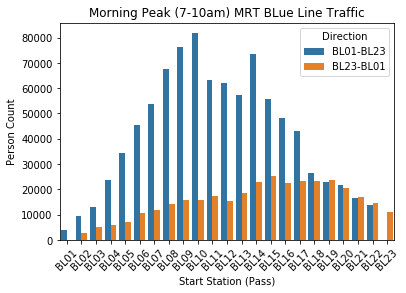

In [585]:
labels=["BL23-BL01", "BL01-BL23"]
mp_odd_sum["Direction"] = mp_odd_sum["direction"].map(dict(zip(range(2), labels)))

g = sns.barplot(x="pass_startS_label", y="person", hue="Direction", data=mp_odd_sum)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
g.set(xlabel='Start Station (Pass)', ylabel='Person Count')
g.set_title("Morning Peak (7-10am) MRT BLue Line Traffic")

plt.savefig('morning_peak_BL.png', dpi=100)

plt.show()

#### 2. Plot the Sources of the Congestion

In [643]:
hm_nbl_start = (
    cong_odd.loc[(cong_odd.person > 100) & (~cong_odd.startS_label.str.contains('BL')), ['startS_label', 'endS_label', 'person']]
    .groupby(['endS_label', 'startS_label'])
    .sum()
    .unstack(level=0)
    .fillna(0)
)

hm_nbl_start

person                                   
endS_label     BL16   BL17   BL18   BL23   BR16   BR17
startS_label                                          
O01           105.0    0.0  204.0  102.0  130.0  102.0
O02             0.0    0.0  297.0  112.0  111.0  107.0
O03           114.0    0.0  359.0  136.0  108.0    0.0
O04           141.0  120.0  568.0  165.0  234.0  112.0
O05             0.0    0.0  108.0    0.0    0.0    0.0
O50             0.0    0.0  103.0    0.0    0.0    0.0
O51             0.0    0.0  136.0    0.0    0.0    0.0
O52             0.0    0.0  110.0    0.0    0.0    0.0
O53             0.0    0.0  120.0    0.0    0.0    0.0
O54             0.0    0.0  165.0    0.0    0.0    0.0
R17             0.0    0.0  115.0    0.0    0.0    0.0

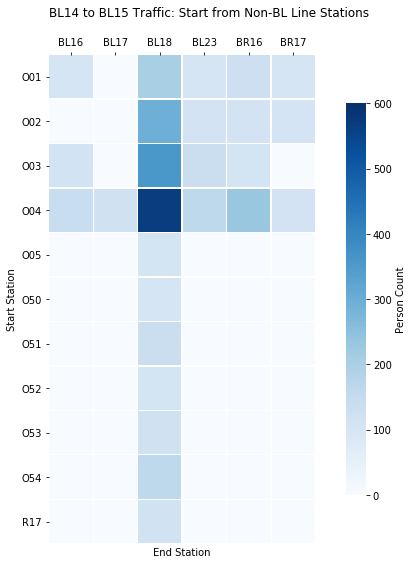

In [644]:
fig, ax = plt.subplots(figsize=(11, 9))

g = sns.heatmap(hm_nbl_start, cmap="Blues", vmin= 0, vmax=600, 
                square=True, linewidth=0.3, 
                cbar_kws={"shrink": .8, 'label': 'Person Count'})

ax.xaxis.tick_top()
xticks_labels = ['BL16', 'BL17', 'BL18', 'BL23', 'BR16', 'BR17']
plt.xticks(np.arange(6) + .5, labels=xticks_labels)

plt.xlabel('End Station')
plt.ylabel('Start Station')

g.set_yticklabels(g.get_yticklabels(), rotation=0)

title = 'BL14 to BL15 Traffic: Start from Non-BL Line Stations\n'
g.set_title(title, loc='left')

plt.savefig('BL14_BL15_traffic_from_nonBL.png', dpi=100)

plt.show()

In [645]:
hm_nbl_end = (
    cong_odd.loc[(cong_odd.person > 100) & (~cong_odd.endS_label.str.contains('BL')), ['startS_label', 'endS_label', 'person']]
    .groupby(['endS_label', 'startS_label'])
    .sum()
    .unstack(level=0)
    .fillna(0)
)

hm_nbl_end

person                     
endS_label     BR08   BR09   BR16   BR17
startS_label                            
BL04            0.0    0.0  156.0  103.0
BL05            0.0    0.0  261.0  110.0
BL06            0.0    0.0  156.0  102.0
BL07            0.0    0.0  143.0  113.0
BL08            0.0  232.0  379.0  150.0
BL09            0.0    0.0  161.0  111.0
BL12          358.0    0.0  329.0    0.0
O01             0.0    0.0  130.0  102.0
O02             0.0    0.0  111.0  107.0
O03             0.0    0.0  108.0    0.0
O04             0.0    0.0  234.0  112.0

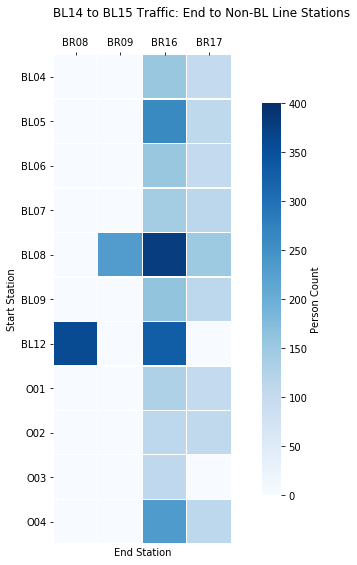

In [652]:
fig, ax = plt.subplots(figsize=(11, 9))

g = sns.heatmap(hm_nbl_end, cmap="Blues", vmin= 0, vmax=400, 
                square=True, linewidth=0.3, 
                cbar_kws={"shrink": .8, 'label': 'Person Count'})

ax.xaxis.tick_top()
xticks_labels = ['BR08', 'BR09', 'BR16', 'BR17']
plt.xticks(np.arange(4) + .5, labels=xticks_labels)

plt.xlabel('End Station')
plt.ylabel('Start Station')

g.set_yticklabels(g.get_yticklabels(), rotation=0)

title = 'BL14 to BL15 Traffic: End to Non-BL Line Stations\n'
g.set_title(title, loc='left')

plt.savefig('BL14_BL15_traffic_to_nonBL.png', dpi=100)

plt.show()